In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
#import base
from typing import List, Callable, Union, Any, TypeVar, Tuple

Tensor = TypeVar('torch.tensor')

In [2]:
class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim) #
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim) #


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]* 4)#

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)

        #kld_loss = -torch.sum(1 + torch.log(log_var.pow(2)) - mu.pow(2) - log_var.pow(2))
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [3]:
# config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 3 #*32 * 3
hidden_dim = 200
latent_dim = 128
num_epochs = 10
batch_size = 32
lr = 3e-4

In [4]:
# load cifar10 dataset
cifar_dataset = datasets.CIFAR10(root='cifar_dataset', train=True, transform=transforms.ToTensor(), download=True)
cifar_loader = DataLoader(dataset=cifar_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [5]:
transform = transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
])

# load celeba dataset
celeba_dataset = datasets.CelebA(root='cifar_dataset', transform=transform, download=True)
celeba_loader = DataLoader(dataset=celeba_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified


In [6]:
features, labels = next(iter(celeba_loader))
features.shape

torch.Size([32, 3, 32, 32])

In [7]:
model = VanillaVAE(in_channels=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
# test loss function
features, labels = next(iter(cifar_loader))
features.shape
x_reconstructed, x, mu, sigma = model(features.to(device))
loss, reconstruction_loss, kl_div = model.loss_function(x_reconstructed, x, mu, sigma, M_N=1).values()

print(loss.item())

17.595182418823242


In [9]:
train = False  # False means loading an existing model instead of training a new one
PATH = 'models/cifar_vae.pth'

if train:
    # start training
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(cifar_loader))

        for i, (x, _) in loop:
            # forward pass
            x = x.to(device)
            x_reconstructed, x, mu, sigma = model(x)

            # compute loss
            loss, reconstruction_loss, kl_div = model.loss_function(x_reconstructed, x, mu, sigma, M_N=0.00025).values()

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

else:
    model.load_state_dict(torch.load(PATH))

In [10]:
# print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# save model
#torch.save(model.state_dict(), PATH)

Model's state_dict:
encoder.0.0.weight 	 torch.Size([64, 3, 3, 3])
encoder.0.0.bias 	 torch.Size([64])
encoder.0.1.weight 	 torch.Size([64])
encoder.0.1.bias 	 torch.Size([64])
encoder.0.1.running_mean 	 torch.Size([64])
encoder.0.1.running_var 	 torch.Size([64])
encoder.0.1.num_batches_tracked 	 torch.Size([])
encoder.1.0.weight 	 torch.Size([128, 64, 3, 3])
encoder.1.0.bias 	 torch.Size([128])
encoder.1.1.weight 	 torch.Size([128])
encoder.1.1.bias 	 torch.Size([128])
encoder.1.1.running_mean 	 torch.Size([128])
encoder.1.1.running_var 	 torch.Size([128])
encoder.1.1.num_batches_tracked 	 torch.Size([])
encoder.2.0.weight 	 torch.Size([256, 128, 3, 3])
encoder.2.0.bias 	 torch.Size([256])
encoder.2.1.weight 	 torch.Size([256])
encoder.2.1.bias 	 torch.Size([256])
encoder.2.1.running_mean 	 torch.Size([256])
encoder.2.1.running_var 	 torch.Size([256])
encoder.2.1.num_batches_tracked 	 torch.Size([])
encoder.3.0.weight 	 torch.Size([512, 256, 3, 3])
encoder.3.0.bias 	 torch.Size([512])

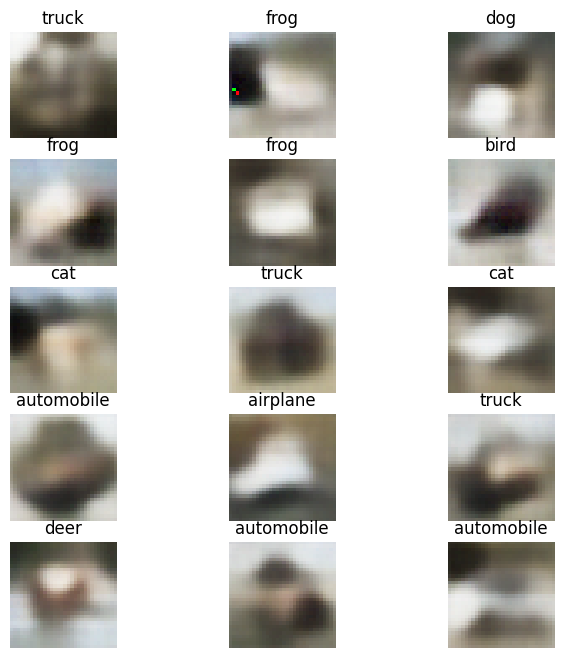

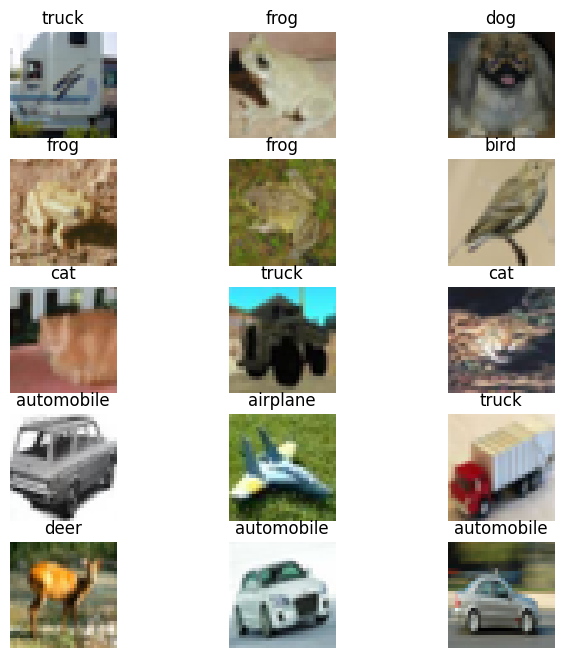

In [11]:
model.to('cpu')

# labels of cifar10 dataset
cifar_labels = {0:'airplane',
                1:'automobile',
                2:'bird',
                3:'cat',
                4:'deer',
                5:'dog',
                6:'frog',
                7:'horse',
                8:'ship',
                9:'truck'}

# shows reconstructed samples
fig1 = plt.figure(figsize=(8, 8))
cols, rows = 3, 5
images = []
results = []

for idx in range(1, cols * rows + 1):
    features, labels = next(iter(cifar_loader))
    input = features[0].view(1,3,32,32)
    label = labels[0].item()
    images.append((input[0].detach().numpy().transpose(1,2,0), label))

    # generate image
    img = model.generate(input)
    out = img.detach().numpy()[0].transpose(1,2,0)
    results.append(out * 255)

    # plot image
    fig1.add_subplot(rows, cols, idx)
    plt.title(cifar_labels[label])
    plt.axis("off")
    plt.imshow((out*255).astype(np.uint8))

# shows original samples
fig2 = plt.figure(figsize=(8,8))

for i, (x, y) in enumerate(images):
    #img = x[0].detach().numpy().transpose(1,2,0)

    # plot image
    fig2.add_subplot(rows, cols, i+1)
    plt.title(cifar_labels[y])
    plt.axis("off")
    plt.imshow(x)

In [12]:
model2 = VanillaVAE(in_channels=input_dim, latent_dim=latent_dim).to(device)

train = False
PATH = 'models/celeba_vae.pth'

if train:

    num_epochs = 5
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(celeba_loader))

        for i, (x, y) in loop:
            # forward pass
            #x = x.to(device).view(batch_size, input_dim)
            x = x.to(device)
            x_reconstructed, x, mu, sigma = model2.forward(x, labels=y)

            # compute loss
            loss, reconstruction_loss, kl_div = model2.loss_function(x_reconstructed, x, mu, sigma, M_N=0.00015).values()
            #print(reconstruction_loss, kl_div)

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loop.set_postfix(loss=loss.item())

else:
    model2.load_state_dict(torch.load(PATH))

In [13]:
# saves the model
PATH = 'models/celeba_vae.pth'
#torch.save(model2.state_dict(), PATH)

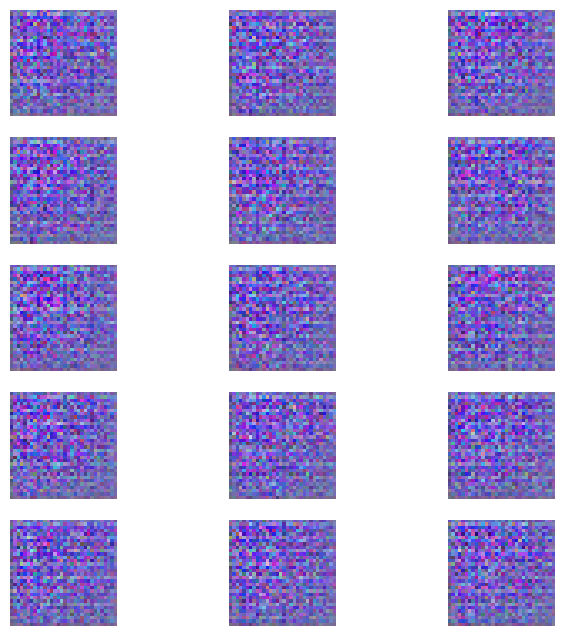

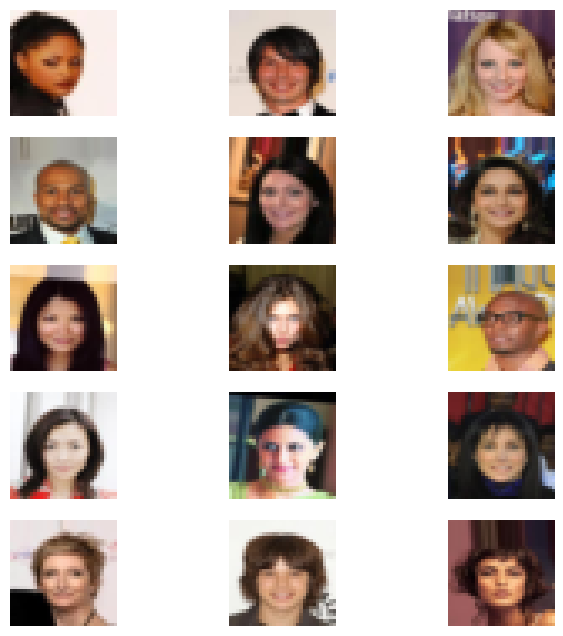

In [14]:
model2 = model2.to('cpu')

# shows reconstructed samples
fig1 = plt.figure(figsize=(8, 8))
cols, rows = 3, 5
images = []
results = []

for idx in range(1, cols * rows + 1):
    features, labels = next(iter(celeba_loader))
    input = features[0].view(1,3,32,32)
    images.append((input[0].detach().numpy().transpose(1,2,0), label))

    # generate image
    img = model2.generate(input)
    out = img[0].detach().numpy().transpose(1,2,0)
    out = (out + 1) / 2
    results.append(out * 255)

    # plot image
    fig1.add_subplot(rows, cols, idx)
    plt.axis("off")
    plt.imshow((out*255).astype(np.uint8))

# shows original samples
fig2 = plt.figure(figsize=(8,8))

for i, (x, y) in enumerate(images):
    #img = x[0].detach().numpy().transpose(1,2,0)

    # plot image
    fig2.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(x)

In [15]:
# Code derived from tensorflow/tensorflow/models/image/imagenet/classify_image.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import sys
import tarfile

import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys

In [16]:
MODEL_DIR = 'models/inception/'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

In [17]:
# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  print(filepath)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.GFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')#
    print(pool3)
    ops = pool3.graph.get_operations()
    print(ops)
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            #print(o)
            #shape = [s.value for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)

if softmax is None:
  _init_inception()

models/inception/inception-2015-12-05.tgz
Tensor("pool_3:0", shape=(1, 1, 1, 2048), dtype=float32)
[<tf.Operation 'DecodeJpeg/contents' type=Const>, <tf.Operation 'DecodeJpeg' type=DecodeJpeg>, <tf.Operation 'Cast' type=Cast>, <tf.Operation 'ExpandDims/dim' type=Const>, <tf.Operation 'ExpandDims' type=ExpandDims>, <tf.Operation 'ResizeBilinear/size' type=Const>, <tf.Operation 'ResizeBilinear' type=ResizeBilinear>, <tf.Operation 'Sub/y' type=Const>, <tf.Operation 'Sub' type=Sub>, <tf.Operation 'Mul/y' type=Const>, <tf.Operation 'Mul' type=Mul>, <tf.Operation 'conv/conv2d_params' type=Const>, <tf.Operation 'conv/Conv2D' type=Conv2D>, <tf.Operation 'conv/batchnorm/beta' type=Const>, <tf.Operation 'conv/batchnorm/gamma' type=Const>, <tf.Operation 'conv/batchnorm/moving_mean' type=Const>, <tf.Operation 'conv/batchnorm/moving_variance' type=Const>, <tf.Operation 'conv/batchnorm' type=BatchNormWithGlobalNormalization>, <tf.Operation 'conv/CheckNumerics' type=CheckNumerics>, <tf.Operation 'con

In [19]:
num_images = 400
results = []

for idx in range(1, num_images + 1):
    features, labels = next(iter(cifar_loader))
    input = features[0].view(1,3,32,32)
    img = model.generate(input)
    img = img.detach().numpy()[0].transpose(1,2,0)
    results.append(img)

processed_res = [x*255 for x in results]
print('Cifar10 images inception score:')
get_inception_score(processed_res)

Cifar10 images inception score:
................................................................................................................................................................................................................................................................................................................................................................................................................

(1.9795742, 0.10150378)

In [20]:
num_images = 400
results = []

for idx in range(1, num_images + 1):
    features, labels = next(iter(cifar_loader))
    input = features[0].view(1,3,32,32)
    img = model2.generate(input)
    img = img.detach().numpy()[0].transpose(1,2,0)
    results.append((img + 1) / 2)

processed_res = [x*255 for x in results]
print('CelebA images inception score:')
get_inception_score(processed_res)

CelebA images inception score:
................................................................................................................................................................................................................................................................................................................................................................................................................

(1.2065216, 0.021084307)